# Matrix completion and recommender systems

[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.

This data set consists of:
- 100000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly              ordered. This is a tab separated list of

```
user id | item id | rating | timestamp
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the dataset from the `movielens.csv` file.

In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/NAML/LABS/LAB03/movielens.csv'

In [4]:
dataset = pd.read_csv(file_path, sep = '\t', header = None)
dataset.describe()

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


How many movies? How many people? How many ratings?

In [5]:
rows = np.array(dataset[0]) - 1
cols = np.array(dataset[1]) - 1
vals = np.array(dataset[2])

n = rows.max() + 1
p = cols.max() + 1
d = len(rows)

print('%d people' % n)
print('%d movies' % p)
print('%d ratings' % d)

943 people
1682 movies
100000 ratings


Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).

In [6]:
idxs = np.arange(d)
np.random.seed(1) # for reproducibility
np.random.shuffle(idxs)
rows = rows[idxs]
cols = cols[idxs]
vals = vals[idxs]

Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.

In [7]:
training_data = 80000

rows_train = rows[:training_data]
cols_train = cols[:training_data]
vals_train = vals[:training_data]
rows_test  = rows[training_data:]
cols_test  = cols[training_data:]
vals_test  = vals[training_data:]

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:
$$
X_{i,j} =
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$

In [8]:
X_sparse = csr_matrix((vals_train, (rows_train, cols_train)), shape = (n,p))
X_full = X_sparse.toarray()

In [9]:
X_full.shape

(943, 1682)

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:
$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$
where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):
$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$
and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):
$$
\rho =
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$
where
$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r_{ij}
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r^{\text{pred}}_{ij}
\end{split}
$$

In [10]:
avg_ratings = np.array([np.mean(vals_train[rows_train == i]) for i in range(n)])
vals_trivial = avg_ratings[rows_test]

# avg_ratings = np.array([np.mean(vals_train[cols_train == i]) for i in range(p)])
# avg_ratings[np.isnan(avg_ratings)] = np.mean(vals_train)
# vals_trivial = avg_ratings[cols_test]

errors_trivial = vals_test - vals_trivial

RMSE_trivial = np.sqrt(np.mean(errors_trivial**2))
rho_trivial = pearsonr(vals_test, vals_trivial)[0]
print('RMSE: %1.3f' % RMSE_trivial)
print('rho : %1.3f' % rho_trivial)

RMSE: 1.043
rho : 0.384


# Singular value truncation (SVT) based recommender system

Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.

In [11]:
n_max_iter = 100
threshold  = 100.0
increment_tol = 1e-6

RMSE_list = list()
rho_list = list()

A = X_full.copy()
for i in range(n_max_iter):
    A_old = A.copy()
    U,s,VT = np.linalg.svd(A, full_matrices = False)

    s[s < threshold] = 0
    A = U @ np.diag(s) @ VT

    A[rows_train,cols_train] = vals_train
    increment = np.linalg.norm(A - A_old)

    vals_predicted = A[rows_test,cols_test]
    errors = vals_test - vals_predicted

    RMSE_list.append(np.sqrt(np.mean(errors**2)))
    rho_list.append(pearsonr(vals_test,vals_predicted)[0])

    print('=============== Iteration %d - increment norm %1.3e' % (i+1, increment))
    print('RMSE: %1.3f' % RMSE_list[-1])
    print('rho:  %1.3f' % rho_list[-1])
    if increment < increment_tol:
        break


=============== Iteration 1 - increment norm 4.308e+02
RMSE: 2.611
rho:  0.314
=============== Iteration 2 - increment norm 2.581e+02
RMSE: 2.166
rho:  0.342
=============== Iteration 3 - increment norm 1.843e+02
RMSE: 1.919
rho:  0.364
=============== Iteration 4 - increment norm 1.433e+02
RMSE: 1.758
rho:  0.381
=============== Iteration 5 - increment norm 1.171e+02
RMSE: 1.645
rho:  0.395
=============== Iteration 6 - increment norm 9.887e+01
RMSE: 1.561
rho:  0.407
=============== Iteration 7 - increment norm 8.547e+01
RMSE: 1.495
rho:  0.417
=============== Iteration 8 - increment norm 7.521e+01
RMSE: 1.443
rho:  0.426
=============== Iteration 9 - increment norm 6.711e+01
RMSE: 1.400
rho:  0.433
=============== Iteration 10 - increment norm 6.056e+01
RMSE: 1.364
rho:  0.440
=============== Iteration 11 - increment norm 5.516e+01
RMSE: 1.334
rho:  0.445
=============== Iteration 12 - increment norm 5.063e+01
RMSE: 1.308
rho:  0.451
=============== Iteration 13 - increment norm 4.6

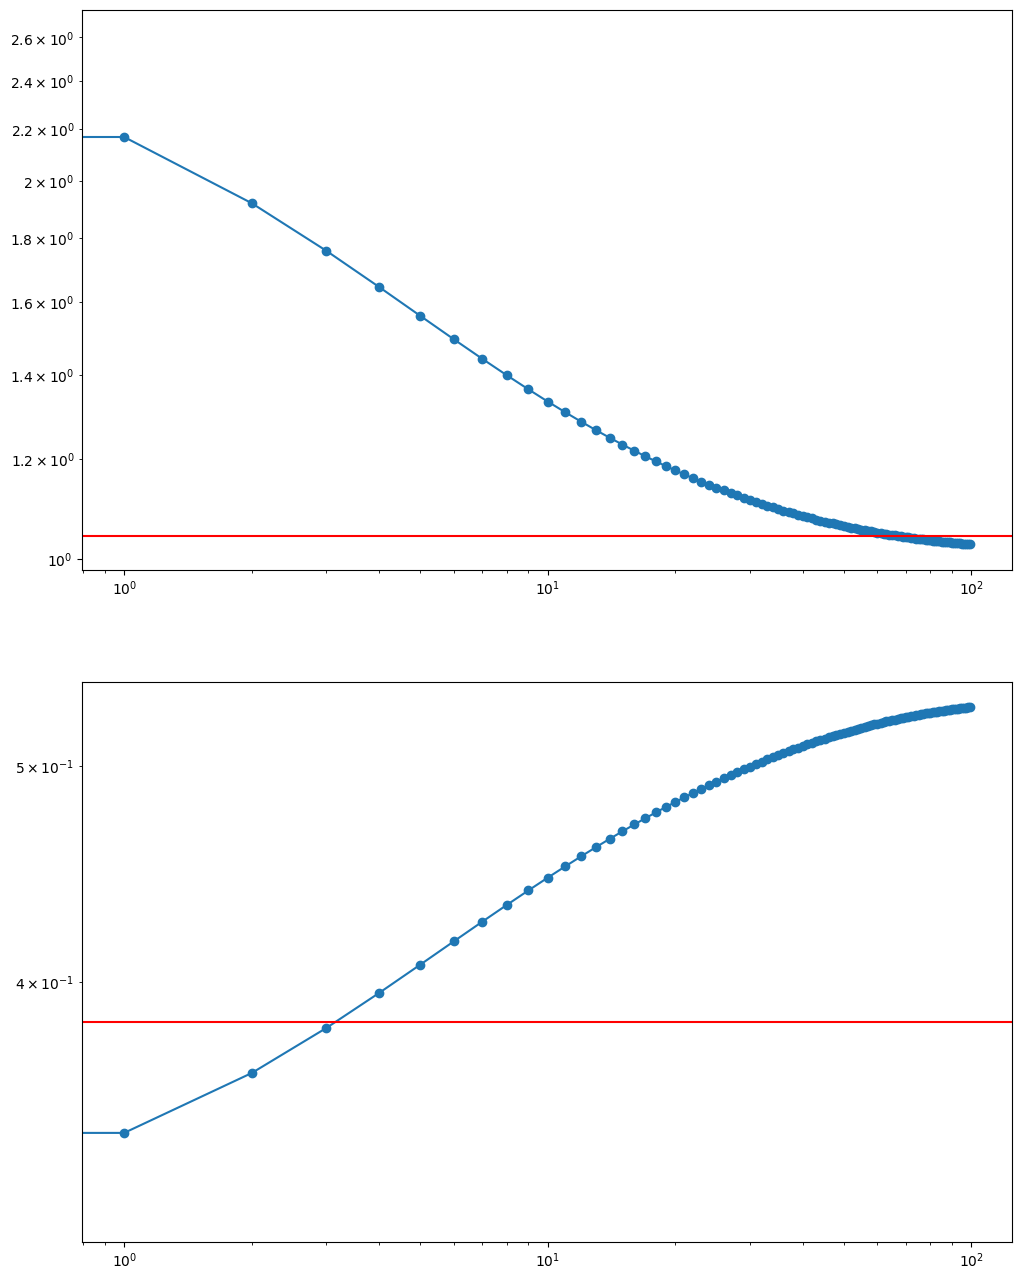

In [12]:
fig, axs = plt.subplots(2,1,figsize = (12,16))

axs[0].loglog(RMSE_list, 'o-')
axs[0].axhline(RMSE_trivial, color = 'red')

axs[1].loglog(rho_list, 'o-')
axs[1].axhline(rho_trivial, color = 'red')